In [3]:
import pandas as pd

# Load the data
data_path = '/content/sample_data/SARIMX_복합SCFI_2017.xlsx'
data = pd.read_excel(data_path)

# Display the first few rows of the dataframe and its summary information
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YYYYMM     45 non-null     object 
 1   CH_EXP     45 non-null     int64  
 2   FLEET_DEV  45 non-null     int64  
 3   SCFI_C     45 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.5+ KB


(    YYYYMM    CH_EXP  FLEET_DEV    SCFI_C
 0  2014-01  21790540   17312194  1174.866
 1  2014-02   9977430   17385239  1069.362
 2  2014-03  17115050   17367549   969.145
 3  2014-04  20089670   17534040  1078.462
 4  2014-05  20500550   17701139  1137.112,
 None)

In [4]:
# Convert 'YYYYMM' to datetime
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')

# Sort data by date just in case
data.sort_values('YYYYMM', inplace=True)

# Split the data into training and testing sets
train_data = data[:-6]
test_data = data[-6:]

# Check the first few rows of the train and test data to ensure correctness
train_data.tail(), test_data.head()


(       YYYYMM    CH_EXP  FLEET_DEV   SCFI_C
 34 2016-11-01  20824460   20192480  820.398
 35 2016-12-01  21837490   20193336  838.530
 36 2017-01-01  21284900   20180978  971.137
 37 2017-02-01  12209240   20120912  869.975
 38 2017-03-01  20313340   20119138  775.174,
        YYYYMM    CH_EXP  FLEET_DEV   SCFI_C
 39 2017-04-01  20762520   20204723  834.060
 40 2017-05-01  22420040   20284035  860.922
 41 2017-06-01  21761190   20344707  869.764
 42 2017-07-01  22736570   20442759  878.540
 43 2017-08-01  23161930   20562089  864.205)

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the model with initial parameters
model = SARIMAX(train_data['SCFI_C'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                exog=train_data[['CH_EXP', 'FLEET_DEV']],
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model
fitted_model = model.fit(disp=False)

# Forecast on the test set
test_exog = test_data[['CH_EXP', 'FLEET_DEV']]
forecast = fitted_model.get_forecast(steps=6, exog=test_exog)
forecast_mean = forecast.predicted_mean

# Calculate RMSE for the test data
test_rmse = np.sqrt(mean_squared_error(test_data['SCFI_C'], forecast_mean))

# Forecast on the training set (for comparison)
train_forecast = fitted_model.get_prediction(start=train_data.index[0], end=train_data.index[-1], exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_forecast_mean = train_forecast.predicted_mean

# Calculate RMSE for the training data
train_rmse = np.sqrt(mean_squared_error(train_data['SCFI_C'], train_forecast_mean))

# Display the RMSEs
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Training RMSE: 2563.540468432794
Test RMSE: 77.28384943162641


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [6]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                             SCFI_C   No. Observations:                   39
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 -66.530
Date:                            Fri, 24 May 2024   AIC                            147.061
Time:                                    06:54:54   BIC                            150.455
Sample:                                         0   HQIC                           145.804
                                             - 39                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CH_EXP     -2.241e-05   3.61e-05     -0.621      0.534   -9.31e-05    4.83e-05
FLEET_DEV     -0.0007      0.001     -1.184      0.236      -0.002       0.000
ar.L1         -0.2565      2.510     -0.102      0.919      -5.176       4.663
ma.L1          0.3889      1.897      0.205      0.838      -3.329       4.107
ar.S.L12       0.1272      1.751      0.073      0.942      -3.305       3.559
ma.S.L12       0.1154      1.376      0.084      0.933      -2.581       2.812
sigma2      6889.4718      0.000   2.17e+07      0.000    6889.471    6889.472
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                 1.76
Prob(Q):                              0.59   Prob(JB):                         0.41
Heteroskedasticity (H):               2.02   Skew:                            -0.94
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.67e+24. Standard errors may be unstable.
"""

(임시) 예측결과 그래프 세부 확대 필요

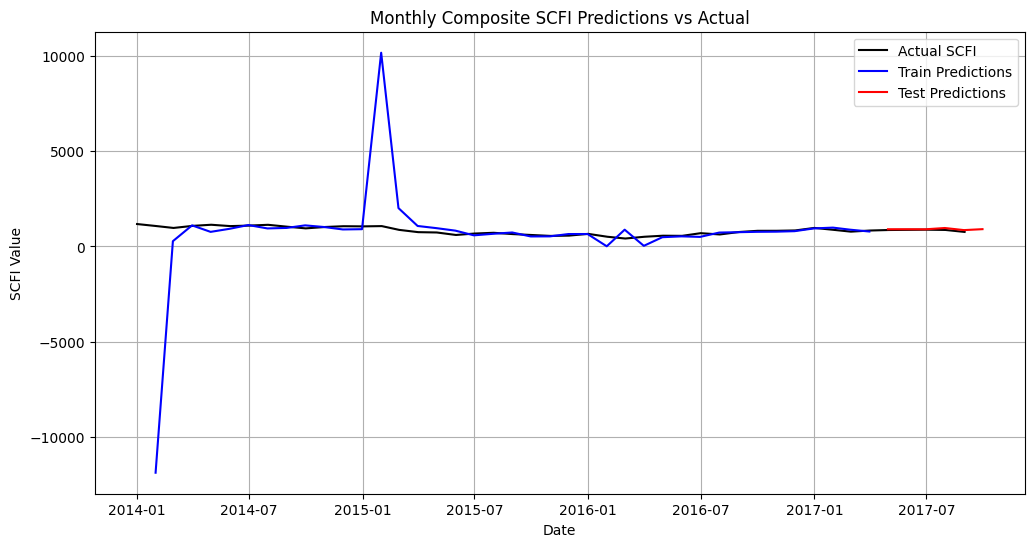

In [7]:
# Predictions on training data
train_forecast = fitted_model.get_prediction(exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_forecast_mean = train_forecast.predicted_mean

# Prepare data for plotting
plot_data = pd.concat([train_forecast_mean, forecast_mean], axis=0)
plot_data.index = pd.date_range(start=data['YYYYMM'].min(), periods=len(plot_data), freq='M')

# Import plotting library
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.legend()
plt.grid(True)
plt.show()


# 도표 18-18. SARIMA(1, 1, 1)(1, 1, 1, 12)의 예측 결과

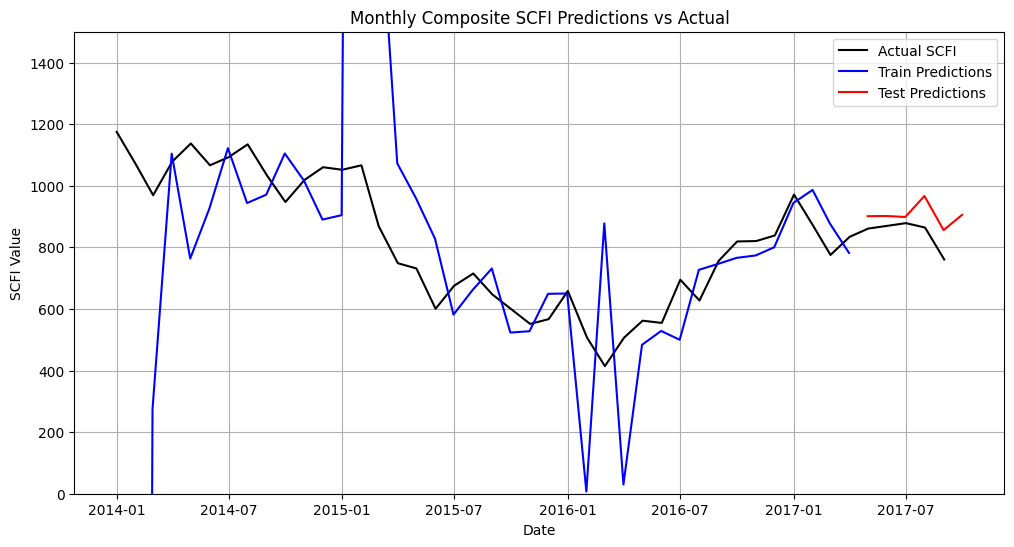

In [9]:
# Plotting with adjusted y-axis
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.ylim(0, 1500)  # Setting the y-axis limits
plt.legend()
plt.grid(True)
plt.show()


(참조용) 시간 경과에 따른 잔차 변화

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


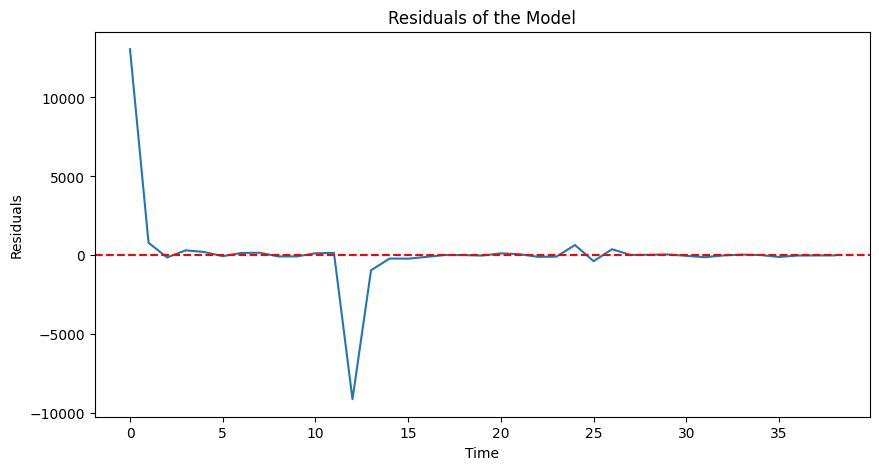

(None,
      lb_stat  lb_pvalue
 10  0.327805   0.999999,
 147.06089187061886,
 150.45523841913487)

In [10]:
# Import plotting library
import matplotlib.pyplot as plt

# 모델 정합성 평가
# Fit the SARIMAX model as previously outlined
model = SARIMAX(train_data['SCFI_C'],
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12),
                exog=train_data[['CH_EXP', 'FLEET_DEV']],
                enforce_stationarity=False,
                enforce_invertibility=False)
fitted_model = model.fit(disp=False)

# Retrieve the residuals
residuals = fitted_model.resid

# Perform Ljung-Box test on residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)

# AIC and BIC values
aic = fitted_model.aic
bic = fitted_model.bic

# Residuals plot
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of the Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show(), ljung_box_result, aic, bic


In [11]:
ljung_box_result

,lb_stat,lb_pvalue
10,0.327805,0.999999


# 저자가 요청한 하이퍼파라미터 최적화에 대해 ChatGPT가 생성한 코드를 코랩에서 실행

In [12]:
# 필요한 라이브러리 설치
!pip install pmdarima

import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')
data.sort_values('YYYYMM', inplace=True)

# 훈련 데이터와 테스트 데이터 분리
train_data = data[:-6]
test_data = data[-6:]

# auto_arima를 사용하여 최적의 파라미터 찾기
smodel = auto_arima(train_data['SCFI_C'],
                    exogenous=train_data[['CH_EXP', 'FLEET_DEV']],
                    seasonal=True, m=12,
                    start_p=0, start_q=0, max_p=3, max_q=3,
                    start_P=0, start_Q=0, max_P=2, max_Q=2,
                    trace=True, error_action='ignore', suppress_warnings=True,
                    stepwise=True)

# 최적의 파라미터 출력
print("Best model: ", smodel.summary())

# 최적의 모델로 SARIMAX 모델 정의 및 피팅
best_model = SARIMAX(train_data['SCFI_C'],
                     exog=train_data[['CH_EXP', 'FLEET_DEV']],
                     order=smodel.order,
                     seasonal_order=smodel.seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
fitted_model = best_model.fit(disp=False)

# 예측 수행
forecast = fitted_model.get_forecast(steps=len(test_data), exog=test_data[['CH_EXP', 'FLEET_DEV']])
forecast_mean = forecast.predicted_mean

# 예측 결과와 실제 데이터를 함께 그래프로 나타냄
...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=450.982, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=452.888, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=453.319, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=449.538, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=450.986, Time=0.15 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=451.470, Time=0.12 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=452.974, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=452.964, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=453.849, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.367 seconds
Best model:                                 SARIMAX Results                                
Dep. Variable:                      y   No. Observat

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Ellipsis

# Y축의 범위가 넓어서 조정 필요(1차)

도표 18-19. auto_arima 함수를 통한 하이퍼파라미터 튜닝 후, ARIMAX의 예측결과

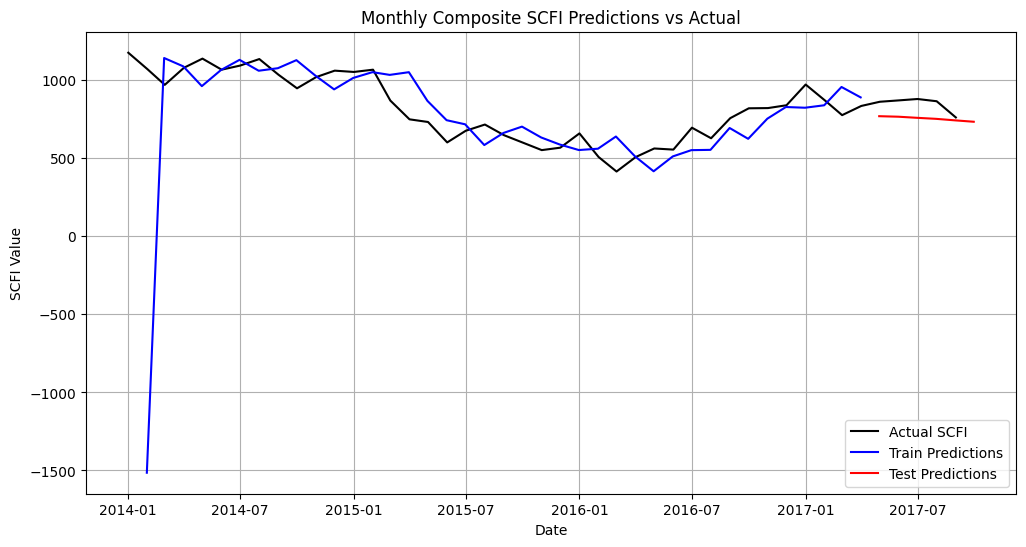

In [21]:
# Predictions on training data
train_forecast = fitted_model.get_prediction(exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_forecast_mean = train_forecast.predicted_mean

# Prepare data for plotting
plot_data = pd.concat([train_forecast_mean, forecast_mean], axis=0)
plot_data.index = pd.date_range(start=data['YYYYMM'].min(), periods=len(plot_data), freq='M')

# Import plotting library
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.legend()
plt.grid(True)
plt.show()


# 도표 18-19. auto_arima 함수를 통한 파라미터 튜닝 후, ARIMAX의 예측결과

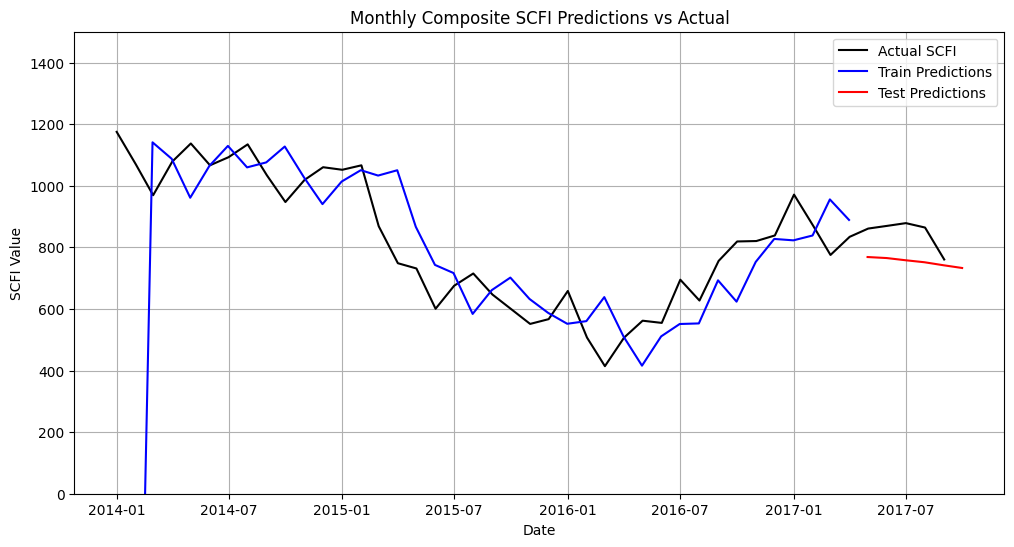

In [22]:
# Plotting with adjusted y-axis
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.ylim(0, 1500)  # Setting the y-axis limits
plt.legend()
plt.grid(True)
plt.show()

# ChatGPT는 추가 질의할 때마다 모형을 처음부터 전처리를 하고 다시 훈련시키다.

In [23]:
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 데이터 불러오기 및 전처리
data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')
data.sort_values('YYYYMM', inplace=True)

# 훈련 데이터와 테스트 데이터 분리
train_data = data[:-6]
test_data = data[-6:]

# auto_arima를 사용하여 최적의 파라미터 찾기
smodel = auto_arima(train_data['SCFI_C'],
                    exogenous=train_data[['CH_EXP', 'FLEET_DEV']],
                    seasonal=True, m=12,
                    start_p=0, start_q=0, max_p=3, max_q=3,
                    start_P=0, start_Q=0, max_P=2, max_Q=2,
                    trace=True, error_action='ignore', suppress_warnings=True,
                    stepwise=True)

# 최적의 파라미터 출력 및 모델 생성
print("Best model: ", smodel.summary())

best_model = SARIMAX(train_data['SCFI_C'],
                     exog=train_data[['CH_EXP', 'FLEET_DEV']],
                     order=smodel.order,
                     seasonal_order=smodel.seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
fitted_model = best_model.fit(disp=False)

# 훈련 데이터에 대한 예측 및 RMSE 계산
train_predictions = fitted_model.predict(start=train_data.index[0], end=train_data.index[-1], exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_rmse = mean_squared_error(train_data['SCFI_C'], train_predictions, squared=False)
print("Training RMSE: ", train_rmse)

# 테스트 데이터에 대한 예측 및 RMSE 계산
forecast = fitted_model.get_forecast(steps=len(test_data), exog=test_data[['CH_EXP', 'FLEET_DEV']])
forecast_mean = forecast.predicted_mean
test_rmse = mean_squared_error(test_data['SCFI_C'], forecast_mean, squared=False)
print("Test RMSE: ", test_rmse)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=450.982, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=452.888, Time=0.38 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=453.319, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=449.538, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=450.986, Time=0.23 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=451.470, Time=0.27 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=452.974, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=452.964, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=453.849, Time=0.26 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 2.782 seconds
Best model:                                 SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   39
Model:               SARIMAX(0, 1, 0)   Log Likeliho

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
print("Training RMSE: ", train_rmse)
print("Test RMSE: ", test_rmse)

Training RMSE:  438.87721541473246
Test RMSE:  98.17147011227442


# auto_arima에서 얻은 하이퍼파라미터를 시작점으로 사용하고, 다른 하이퍼파라미터 조합을 만들어서 RMSE를 개선하도록 하는 코드를 ChatGPT에게 요청한다.

In [44]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


data['YYYYMM'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m')
data.sort_values('YYYYMM', inplace=True)

# 훈련 데이터와 테스트 데이터 분리
train_data = data[:-6]
test_data = data[-6:]

# auto_arima를 사용하여 최적의 파라미터 찾기
smodel = auto_arima(train_data['SCFI_C'],
                    exogenous=train_data[['CH_EXP', 'FLEET_DEV']],
                    seasonal=True, m=12,
                    start_p=0, start_q=0, max_p=3, max_q=3,
                    start_P=0, start_Q=0, max_P=2, max_Q=2,
                    trace=True, error_action='ignore', suppress_warnings=True,
                    stepwise=True)

# 최적의 파라미터 주변의 다양한 조합 시도
best_rmse = np.inf
best_order = None
best_seasonal_order = None
best_model = None

p_range = range(max(0, smodel.order[0]-1), smodel.order[0]+2)
q_range = range(max(0, smodel.order[2]-1), smodel.order[2]+2)
P_range = range(max(0, smodel.seasonal_order[0]-1), smodel.seasonal_order[0]+2)
Q_range = range(max(0, smodel.seasonal_order[2]-1), smodel.seasonal_order[2]+2)

for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    # 현재 조합으로 모델 생성 및 훈련
                    model = SARIMAX(train_data['SCFI_C'],
                                    exog=train_data[['CH_EXP', 'FLEET_DEV']],
                                    order=(p, smodel.order[1], q),
                                    seasonal_order=(P, smodel.seasonal_order[1], Q, 12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    model_fit = model.fit(disp=False)

                    # 훈련 데이터에 대한 RMSE 계산
                    predictions = model_fit.predict(start=train_data.index[0], end=train_data.index[-1], exog=train_data[['CH_EXP', 'FLEET_DEV']])
                    rmse = mean_squared_error(train_data['SCFI_C'], predictions, squared=False)

                    # RMSE가 개선되었는지 확인
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, smodel.order[1], q)
                        best_seasonal_order = (P, smodel.seasonal_order[1], Q, 12)
                        best_model = model_fit

                except Exception as e:
                    print(f"Error with parameters p={p}, q={q}, P={P}, Q={Q}: {str(e)}")

# 최적의 모델로 테스트 데이터에 대한 예측 수행
test_forecast = best_model.get_forecast(steps=len(test_data), exog=test_data[['CH_EXP', 'FLEET_DEV']])
test_predictions = test_forecast.predicted_mean
test_rmse = mean_squared_error(test_data['SCFI_C'], test_predictions, squared=False)

# 결과 출력
print(f"Best Training RMSE: {best_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Best Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=450.982, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=452.888, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=453.319, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=449.538, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=450.986, Time=0.18 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=451.470, Time=0.14 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=452.974, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=452.964, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=453.849, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.599 seconds


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

Best Training RMSE: 433.30717091319065
Test RMSE: 102.51052464247189
Best Order: (0, 1, 1)
Best Seasonal Order: (0, 0, 0, 12)


## ChatGPT 초기 제안 그래프, 가독성을 위해 Y축 조정 필요

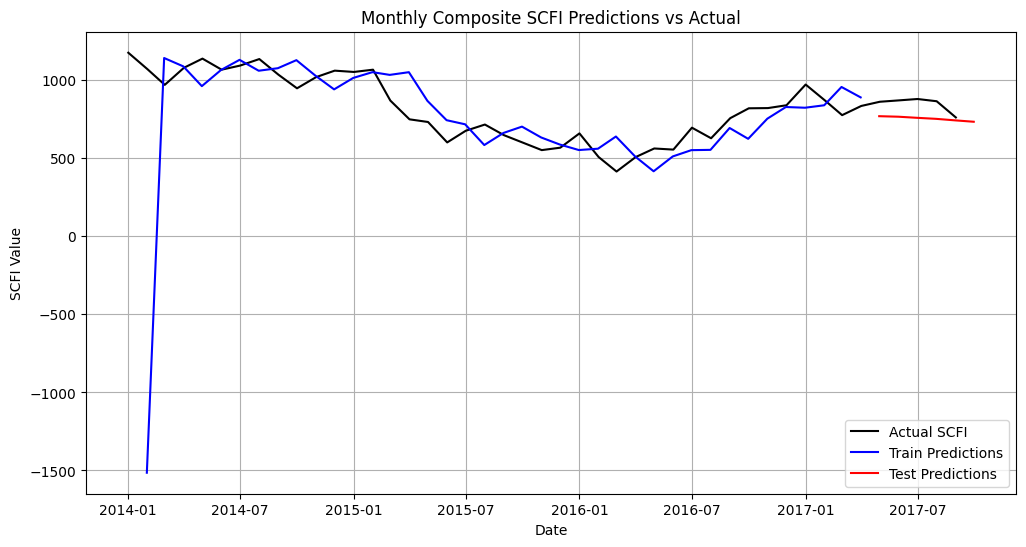

In [45]:

# Predictions on training data
train_forecast = fitted_model.get_prediction(exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_forecast_mean = train_forecast.predicted_mean

# Prepare data for plotting
plot_data = pd.concat([train_forecast_mean, forecast_mean], axis=0)
plot_data.index = pd.date_range(start=data['YYYYMM'].min(), periods=len(plot_data), freq='M')

# Import plotting library
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.legend()
plt.grid(True)
plt.show()

# 도표 18-20. RMSE 최소화 튜닝 후, ARIMAX의 예측결과

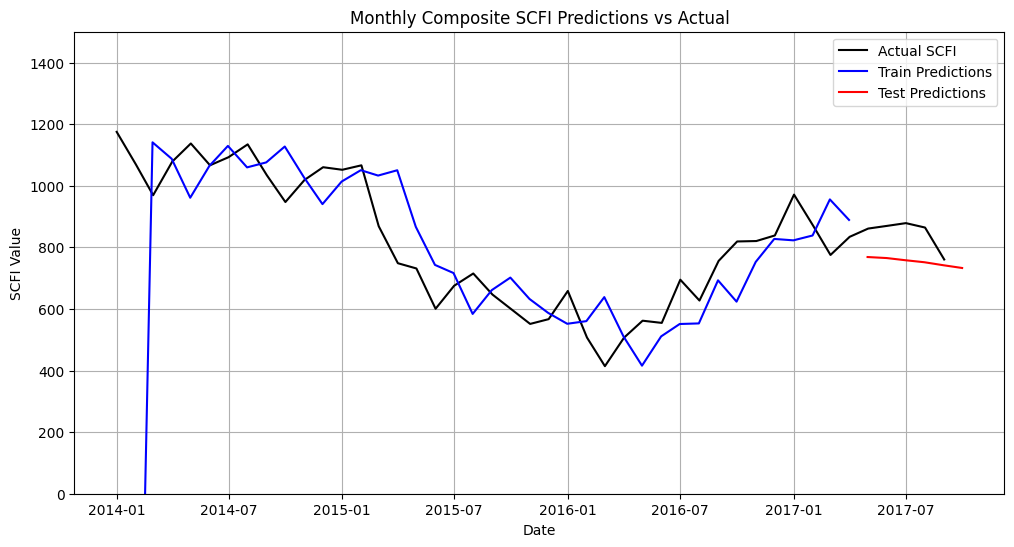

In [46]:
# Plotting with adjusted y-axis
plt.figure(figsize=(12, 6))
plt.plot(data['YYYYMM'], data['SCFI_C'], label='Actual SCFI', color='black')
plt.plot(plot_data.index[:len(train_forecast_mean)], train_forecast_mean, label='Train Predictions', color='blue')
plt.plot(plot_data.index[len(train_forecast_mean):], forecast_mean, label='Test Predictions', color='red')
plt.title('Monthly Composite SCFI Predictions vs Actual')
plt.xlabel('Date')
plt.ylabel('SCFI Value')
plt.ylim(0, 1500)  # Setting the y-axis limits
plt.legend()
plt.grid(True)
plt.show()

(참조용) 잔차 그래프

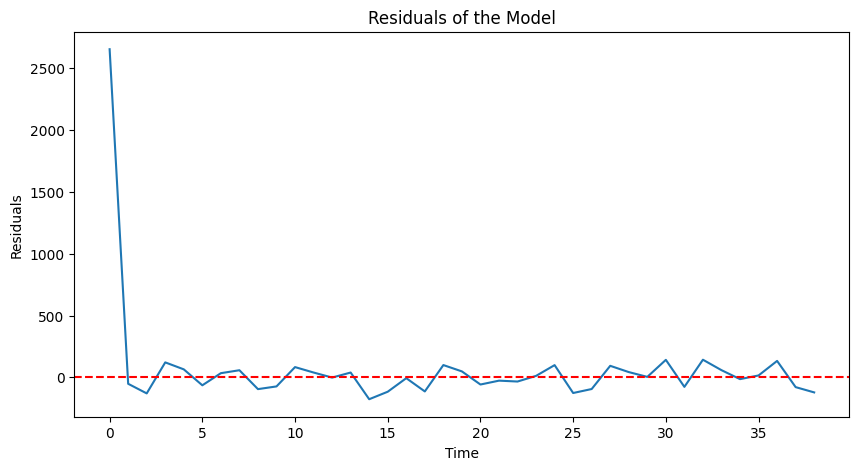

(None,
     lb_stat  lb_pvalue
 10  0.49659   0.999994,
 430.20160579043494,
 436.5356815442594)

In [47]:
# Retrieve the residuals
residuals = best_model.resid

# Perform Ljung-Box test on residuals
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)

# AIC and BIC values
aic = best_model.aic
bic = best_model.bic

# Residuals plot
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals of the Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show(), ljung_box_result, aic, bic


# 도표 18-21. SARIMAX(0, 1, 1)(0, 0, 0, 12) 결과 요약

In [48]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 SCFI_C   No. Observations:                   39
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -211.101
Date:                Fri, 24 May 2024   AIC                            430.202
Time:                        07:42:39   BIC                            436.536
Sample:                             0   HQIC                           432.412
                                 - 39                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CH_EXP      3.949e-06   4.42e-06      0.893      0.372   -4.72e-06    1.26e-05
FLEET_DEV  -9.039e-05      0.000     -0.549      0.583      -0.000       0.000
ma.L1          0.0637      0.201      0.316      0.752      -0.331       0.458
sigma2      7099.7668   5.16e-06   1.38e+09      0.000    7099.767    7099.767
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.54
Prob(Q):                              0.86   Prob(JB):                         0.46
Heteroskedasticity (H):               1.19   Skew:                            -0.13
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+25. Standard errors may be unstable.
"""

# 도표 18-22. SARIMAX 모형 생성과 학습 파이썬 코드

In [49]:
best_model = SARIMAX(train_data['SCFI_C'],
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     exog=train_data[['CH_EXP', 'FLEET_DEV']],
                     enforce_stationarity=False,
                     enforce_invertibility=False)
best_model_fit = best_model.fit(disp=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# 도표 18-23. SARIMAX 훈련데이터와 테스트데이터의 예측 파이썬 코드

In [50]:
# 훈련 데이터 예측
train_forecast = best_model_fit.get_prediction(start=train_data.index[0], end=train_data.index[-1], exog=train_data[['CH_EXP', 'FLEET_DEV']])
train_predictions = train_forecast.predicted_mean

# 테스트 데이터 예측
test_forecast = best_model_fit.get_forecast(steps=len(test_data), exog=test_data[['CH_EXP', 'FLEET_DEV']])
test_predictions = test_forecast.predicted_mean

print(f"Best Training RMSE: {best_rmse}")
print(f"Test RMSE: {test_rmse}")


Best Training RMSE: 433.30717091319065
Test RMSE: 102.51052464247189


(참조용)  enforce_stationarity=True, enforce_invertibility=True 로 설정하고 훈련 시킴

In [51]:
best_model = SARIMAX(train_data['SCFI_C'],
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     exog=train_data[['CH_EXP', 'FLEET_DEV']],
                     enforce_stationarity=True,
                     enforce_invertibility=True)
best_model_fit = best_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
# 최적의 모델로 테스트 데이터에 대한 예측 수행
test_forecast = best_model_fit.get_forecast(steps=len(test_data), exog=test_data[['CH_EXP', 'FLEET_DEV']])
test_predictions = test_forecast.predicted_mean
test_rmse = mean_squared_error(test_data['SCFI_C'], test_predictions, squared=False)

# 결과 출력
print(f"Best Training RMSE: {best_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Best Order: {best_order}")
print(f"Best Seasonal Order: {best_seasonal_order}")


Best Training RMSE: 433.30717091319065
Test RMSE: 102.74643615224272
Best Order: (0, 1, 1)
Best Seasonal Order: (0, 0, 0, 12)
